# MacBook analysis

In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [77]:
cpus = pd.read_csv('../../data/cpus.csv').set_index('name')
gpus = pd.read_csv('../../data/gpus.csv').set_index('name')
macbooks = pd.read_csv('../../data/macbook.csv')

In [78]:
df = macbooks[pd.notna(macbooks.price_hkd)]\
    .assign(
        year=lambda df: pd.to_datetime(df.release).dt.year,
        price=lambda df: (df.price_hkd / 7.75).round()
    )\
    .assign(
        # Remove "MacBook Pro " prefix and concatenate model with release year.
        name=lambda df: df.model.map(str).str.slice(len('MacBook Pro ')) + '@' + df.year.map(str)
    )\
    .drop(columns=['release', 'price_usd', 'price_hkd'])\
    .join(cpus[['passmark', 'price']].add_prefix('cpu_'), how='left', on='cpu')\
    .join(gpus[['passmark']].add_prefix('gpu_'), how='left', on='gpu')\
    .drop(columns=['model', 'year'])

In [125]:
# Get CPU info on linux: https://www.binarytides.com/linux-cpu-information/
# Get GPU info: https://askubuntu.com/questions/5417/how-to-get-the-gpu-info
# apt-get install mesa-utils
# glxinfo | egrep -i 'device|memory'
benchmark = pd.DataFrame([
    ['Dell xps 15', 'Intel Core i7-4712HQ @ 2.30GHz', 'GeForce GT 750M', 16, 512, np.NaN],
    
    # High-end gaming (compare with latest specs)
    # https://www.techradar.com/reviews/razer-blade-2018
    ['Razer Blade', 'Intel Core i7-8750H @ 2.20GHz', 'GeForce GTX 1070 with Max-Q Design', 16, 512, 1870.99],
    # https://www.techradar.com/reviews/msi-gt75-titan
    ['MSI GT75 Titan', 'Intel Core i9-8950HK @ 2.90GHz', 'GeForce GTX 1080', 32, 1024, 2399],
], columns=[
    'name', 'cpu', 'gpu', 'ram', 'storage', 'price',
])\
    .join(cpus[['passmark', 'price']].add_prefix('cpu_'), how='left', on='cpu')\
    .join(gpus[['passmark']].add_prefix('gpu_'), how='left', on='gpu')

benchmark

,name,cpu,gpu,ram,storage,price,cpu_passmark,cpu_price,gpu_passmark
0,Dell xps 15,Intel Core i7-4712HQ @ 2.30GHz,GeForce GT 750M,16,512,NaN,7509,NaN,1294
1,Razer Blade,Intel Core i7-8750H @ 2.20GHz,GeForce GTX 1070 with Max-Q Design,16,512,1870.99,12466,395.0,9273
2,MSI GT75 Titan,Intel Core i9-8950HK @ 2.90GHz,GeForce GTX 1080,32,1024,2399.00,14411,583.0,12389


For some of the CPUs their price is known. Here we compare increase in macbook's price when upgrading processor only and increase in the very same processor on the market. This would indicate sales margin of the company.

* Processor's price is available only for 15-inch model with TouchBar @2018 release.
* Cross-model price difference (comparing i7-8750H @ 2.20GHz model with i7-8850H @ 2.60GHz model)
    * Intel did not increase the price i7-8750H @ 2.20GHz -> i7-8850H @ 2.60GHz.
    * +85.161290 in price and +0 in cpu price
* Same model price difference:
    * i7-8750H @ 2.20GHz to i9-8950HK @ 2.90GHz: + 387.096774 price +188.0 cpu price (+106%)
    * i7-8850H @ 2.60GHz to i9-8950HK @ 2.90GHz: + 301.935484 price +188.0 cpu price (+60%)

In [79]:
df[pd.notna(df.cpu_price)]\
    .sort_values(['name', 'gpu', 'ram', 'storage', 'cpu_passmark'])\
    .assign(
        price_diff=lambda df: df.groupby(['name', 'gpu', 'ram', 'storage']).price.diff(),
        cpu_price_diff=lambda df: df.groupby(['name', 'gpu', 'ram', 'storage']).cpu_price.diff()
    )\
    .pipe(lambda df: df[pd.notna(df.price_diff) & pd.notna(df.cpu_price_diff)])\
    .drop_duplicates(subset=['price_diff', 'cpu_price_diff'], keep='first')

,cpu,gpu,ram,ram_type,storage,price,name,cpu_passmark,cpu_price,gpu_passmark,price_diff,cpu_price_diff
72,Intel Core i9-8950HK @ 2.90GHz,Radeon Pro 555X,16,2400 MHz PC4-19200 DDR4 SDRAM,256,2837.0,15-inch model with Touch Bar@2018,14411,583.0,NaN,387.0,188.0
111,Intel Core i7-8850H @ 2.60GHz,Radeon Pro 560X,16,2400 MHz PC4-19200 DDR4 SDRAM,512,2837.0,15-inch model with Touch Bar@2018,13160,395.0,NaN,85.0,0.0
82,Intel Core i9-8950HK @ 2.90GHz,Radeon Pro 560X,16,2400 MHz PC4-19200 DDR4 SDRAM,512,3139.0,15-inch model with Touch Bar@2018,14411,583.0,NaN,302.0,188.0
112,Intel Core i9-8950HK @ 2.90GHz,Radeon Pro 560X,16,2400 MHz PC4-19200 DDR4 SDRAM,512,3139.0,15-inch model with Touch Bar@2018,14411,583.0,NaN,0.0,0.0
138,Intel Core i9-8950HK @ 2.90GHz,Radeon Pro Vega 16,16,2400 MHz PC4-19200 DDR4 SDRAM,2048,4598.0,15-inch model with Touch Bar@2018,14411,583.0,NaN,301.0,188.0


### Where are MacBook CPUs on the benchmark scale?

In [80]:
df.drop_duplicates(subset=['cpu_passmark'])

,cpu,gpu,ram,ram_type,storage,price,name,cpu_passmark,cpu_price,gpu_passmark
0,Intel Core i5-7360U @ 2.30GHz,Intel Iris Plus 640,8,2133 MHz PC3-17000 LPDDR3 SDRAM,128,1289.0,13-inch model two Thunderbolt 3 ports@2017,5957,NaN,1420.0
1,Intel Core i7-7660U @ 2.50GHz,Intel Iris Plus 640,8,2133 MHz PC3-17000 LPDDR3 SDRAM,128,1591.0,13-inch model two Thunderbolt 3 ports@2017,6031,NaN,1420.0
55,Intel Core i5-8259U @ 2.30GHz,Intel Iris Plus 655,8,2133 MHz PC3-17000 LPDDR3 SDRAM,256,1857.0,13-inch model with Touch Bar@2018,10981,671.63,1947.0
56,Intel Core i7-8559U @ 2.70GHz,Intel Iris Plus 655,8,2133 MHz PC3-17000 LPDDR3 SDRAM,256,2158.0,13-inch model with Touch Bar@2018,12206,NaN,1947.0
71,Intel Core i7-8750H @ 2.20GHz,Radeon Pro 555X,16,2400 MHz PC4-19200 DDR4 SDRAM,256,2450.0,15-inch model with Touch Bar@2018,12466,395.00,NaN
72,Intel Core i9-8950HK @ 2.90GHz,Radeon Pro 555X,16,2400 MHz PC4-19200 DDR4 SDRAM,256,2837.0,15-inch model with Touch Bar@2018,14411,583.00,NaN
111,Intel Core i7-8850H @ 2.60GHz,Radeon Pro 560X,16,2400 MHz PC4-19200 DDR4 SDRAM,512,2837.0,15-inch model with Touch Bar@2018,13160,395.00,NaN


(0, 20000)

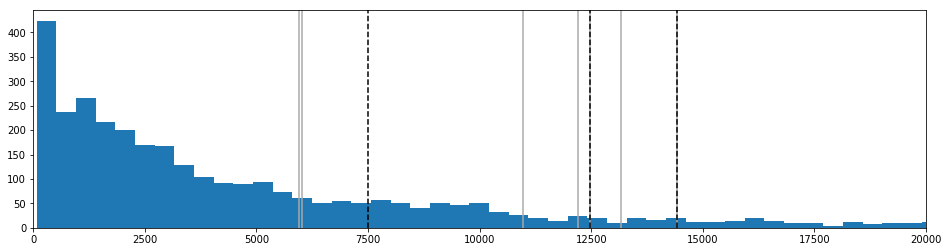

In [126]:
ax = cpus.passmark.hist(bins=100, grid=False, figsize=(16, 4))

for cpu_passmark in df.drop_duplicates(subset=['cpu_passmark']).cpu_passmark.values:
    plt.axvline(cpu_passmark, color='darkgray')

for cpu_passmark in benchmark.drop_duplicates(subset=['cpu_passmark']).cpu_passmark.values:
    plt.axvline(cpu_passmark, color='k', linestyle='--')

ax.set_xlim([0, 20000])

### Where are MacBook GPUs and eGPUs on the benchmark scale?

* 13-inch models GPU passmark ranges [1420, 1947] (Intel Iris card)
* 15-inch models have Radeon Pro card
    * 555X benchmark is not available but compared to 555 and 560 models it should be in the range [3140, 3534]
    * Radeon Pro Vega 20 really imroves the quality (almost 2X) to 6147

In [232]:
egpus = pd.DataFrame([
    # https://www.apple.com/shop/product/HM8Y2VC/A/blackmagic-egpu
    ['Apple Blackmagic eGPU', 'Radeon Pro 580', 699],
    # https://www.apple.com/shop/product/HMQT2VC/A/blackmagic-egpu-pro
    ['Apple Blackmagic eGPU Pro', 'Radeon Pro Vega 56', 1199],
    
    ## Mac supported eGPU (Radeon): https://egpu.io/state-of-egpu-for-macs-mojave-10-14-update/
    
    # Plug and play eGPUs for mac (portable)
    # Blackmagic eGPU Review: https://egpu.io/blackmagic-egpu-review-apples-ultrafine-curse/
    # Sonnet Breakaway Puck: https://egpu.io/sonnet-breakaway-puck-review-pint-sized-compromise/ (portable, 4x Intel performance)
    ['Sonnet Breakaway Puck RX560', 'Radeon RX 560', 399],
    ['Sonnet Breakaway Puck RX570', 'Radeon RX 570', 599],
    # https://egpu.io/gigabyte-rx-580-gaming-box-review-little-middle/
    ['Gigabyte RX 580', 'Radeon RX 580', 600],
    
    # Powerful eGPU supported by Apple with external enclosure requirements
    # https://egpu.io/state-of-egpu-for-macs-mojave-10-14-update/
    ['Pro WX 9100', 'Radeon Pro WX 9100', np.NaN],
    ['Vega Frontier Edition', 'Radeon Vega Frontier Edition', np.NaN],
    ['Pro WX 8200', 'Radeon Pro WX 8200', np.NaN],
    ['Pro WX 7100', 'Radeon Pro WX 7100', np.NaN],
    
    ['RX Vega 64', 'Radeon RX Vega 64', 540],
    ['RX Vega 56', 'Radeon RX Vega 56', 400],
    ['RX 580', 'Radeon RX 580', 230],
    ['RX 570', 'Radeon RX 570', 160],
    
    # Community supported cards
    ['R9 Fury', 'Radeon R9 Fury', np.NaN],
    
    # Builds with Nvidia: https://egpu.io/build-guides/?table_filter=%228th%20%2213-inch%20Macbook%20Pro%22%22
    ['Nvidia RTX 2080', 'GeForce RTX 2080', np.NaN],
    ['Nvidia GTX Titan Xp', 'NVIDIA TITAN Xp', np.NaN],  # no in builds
    ['Nvidia GTX 1080Ti', 'GeForce GTX 1080 Ti', np.NaN],
    ['Nvidia GTX 1080', 'GeForce GTX 1080', np.NaN],
    
    # Recommended cards for machine learning
    ['Nvidia RTX 2070', 'GeForce RTX 2070', np.NaN],
    
], columns=[
    'name', 'gpu', 'price',
])\
    .join(gpus[['passmark', 'price']].add_prefix('gpu_'), how='left', on='gpu')

egpus

,name,gpu,price,gpu_passmark,gpu_price
0,Apple Blackmagic eGPU,Radeon Pro 580,699.0,7753.0,NaN
1,Apple Blackmagic eGPU Pro,Radeon Pro Vega 56,1199.0,11877.0,NaN
2,Sonnet Breakaway Puck RX560,Radeon RX 560,399.0,4393.0,103.99
3,Sonnet Breakaway Puck RX570,Radeon RX 570,599.0,6726.0,99.99
4,Gigabyte RX 580,Radeon RX 580,600.0,8439.0,179.99
5,Pro WX 9100,Radeon Pro WX 9100,NaN,10382.0,NaN
6,Vega Frontier Edition,Radeon Vega Frontier Edition,NaN,11103.0,599.99
7,Pro WX 8200,Radeon Pro WX 8200,NaN,NaN,NaN
8,Pro WX 7100,Radeon Pro WX 7100,NaN,7918.0,499.99
9,RX Vega 64,Radeon RX Vega 64,540.0,11859.0,399.99


In [123]:
df.drop_duplicates(subset=['gpu_passmark'])

,cpu,gpu,ram,ram_type,storage,price,name,cpu_passmark,cpu_price,gpu_passmark
0,Intel Core i5-7360U @ 2.30GHz,Intel Iris Plus 640,8,2133 MHz PC3-17000 LPDDR3 SDRAM,128,1289.0,13-inch model two Thunderbolt 3 ports@2017,5957,NaN,1420.0
55,Intel Core i5-8259U @ 2.30GHz,Intel Iris Plus 655,8,2133 MHz PC3-17000 LPDDR3 SDRAM,256,1857.0,13-inch model with Touch Bar@2018,10981,671.63,1947.0
71,Intel Core i7-8750H @ 2.20GHz,Radeon Pro 555X,16,2400 MHz PC4-19200 DDR4 SDRAM,256,2450.0,15-inch model with Touch Bar@2018,12466,395.00,NaN
115,Intel Core i7-8850H @ 2.60GHz,Radeon Pro Vega 20,16,2400 MHz PC4-19200 DDR4 SDRAM,512,3189.0,15-inch model with Touch Bar@2018,13160,395.00,6147.0


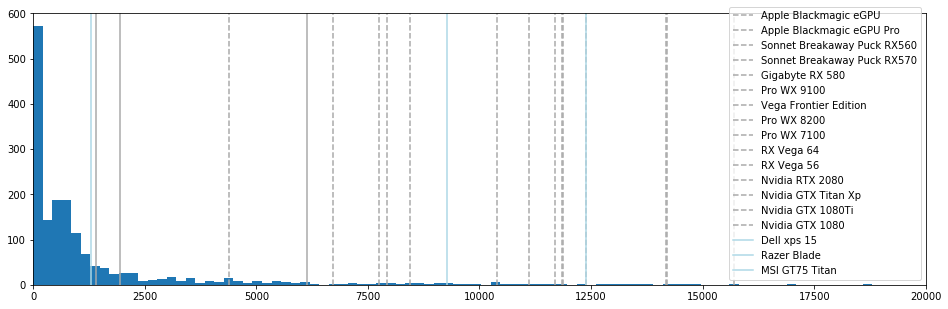

In [162]:
ax = gpus.passmark.hist(bins=100, grid=False, figsize=(16, 5))

for gpu_passmark in df.drop_duplicates(subset=['gpu_passmark']).gpu_passmark.values:
    plt.axvline(gpu_passmark, color='darkgray')

for _, item in egpus.drop_duplicates(subset=['gpu_passmark']).iterrows():
    plt.axvline(item.gpu_passmark, color='darkgray', linestyle='--', label=item['name'])

for _, item in benchmark.drop_duplicates(subset=['gpu_passmark']).iterrows():
    plt.axvline(item.gpu_passmark, color='lightblue', linestyle='-', label=item['name'])


# ax.set_xlim([0, None])
ax.set_xlim([0, 20000])
ax.legend()

In [231]:
gpus.sort_values('passmark', ascending=False).head(n=20)

,passmark,rank,value,price
name,,,,
Quadro RTX 6000,21366,1,3.39,6300.00
TITAN RTX,18712,2,7.49,2499.99
TITAN V CEO Edition,16987,3,NaN,NaN
GeForce RTX 2080 Ti,16953,4,14.25,1189.99
GeForce RTX 2080,15712,5,22.45,699.99
TITAN Xp COLLECTORS EDITION,14759,6,NaN,NaN
TITAN V,14694,7,4.09,3594.00
GeForce RTX 2070,14404,8,28.81,499.99
GeForce GTX 1080 Ti,14204,9,18.21,779.89


In [230]:
gpus.sort_values('value', ascending=False).head(n=20)

,passmark,rank,value,price
name,,,,
Radeon RX 570,6726,76,67.27,99.99
Radeon RX 470,7563,69,63.04,119.99
GeForce GTX 480,4360,135,60.56,71.99
GeForce GTX 1060 3GB,8954,48,52.68,169.99
Radeon HD 7770,2219,251,51.63,42.99
Radeon RX 580,8439,56,46.89,179.99
Radeon RX 480,8116,59,45.09,179.99
GeForce GTX 570,4417,131,44.18,99.99
Radeon RX 550,3442,175,43.03,79.99


No handles with labels found to put in legend.


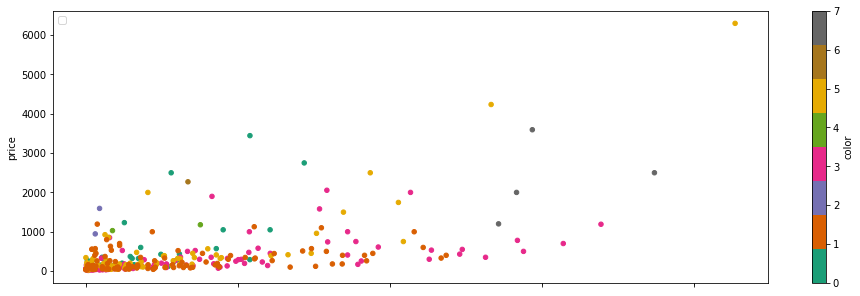

In [226]:
ax = gpus\
    .assign(manufacturer=lambda df: pd.Categorical(np.select([
        df.index.str.lower().str.contains('geforce'),
        df.index.str.lower().str.contains('quadro'),
        df.index.str.lower().str.contains('titan'),
        df.index.str.lower().str.contains('tesla'),
        df.index.str.lower().str.contains('radeon'),
        df.index.str.lower().str.contains('firepro'),
        df.index.str.lower().str.contains('intel'),
        df.index.str.lower().str.contains('grid'),
    ], [
        'Nvidia:GeForce',
        'Nvidia:Quadro',
        'Nvidia:Titan',  # grid computing
        'Nvidia:Tesla',
        'AMD:Radeon',  # copetes with quadro
        'AMD:FirePro',
        'Intel',
        'Nvidia:Grid',
    ], np.NaN)))\
    .pipe(lambda df: df[df['manufacturer'] != 'nan'])\
    .assign(color=lambda df: df['manufacturer'].cat.codes)\
    .plot.scatter(x='passmark', y='price', c='color', colormap='Dark2', figsize=(16, 5))

# Colormaps: https://matplotlib.org/examples/color/colormaps_reference.html
ax.legend(loc='upper left')